In [48]:
import os
os.environ['KERAS_BACKEND']='tensorflow'
import tensorflow
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.models import load_model

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import spectral
import datetime
import h5py

init_notebook_mode(connected=True)
%matplotlib inline

# Data Loading

In [49]:
def prt(name):
    print(name)
fname = 'E:\\Projects\\Projects_for_Jupyter_Notebooks\\COURSE_AI_INTRO\\HybridSN-master\\SOTA-IP-6700epoch-best-model.hdf5'
f = h5py.File(fname,'r')
f.visit(prt)
f.close()

model_weights
model_weights/conv2d_16
model_weights/conv2d_16/conv2d_16
model_weights/conv2d_16/conv2d_16/bias:0
model_weights/conv2d_16/conv2d_16/kernel:0
model_weights/conv3d_46
model_weights/conv3d_46/conv3d_46
model_weights/conv3d_46/conv3d_46/bias:0
model_weights/conv3d_46/conv3d_46/kernel:0
model_weights/conv3d_47
model_weights/conv3d_47/conv3d_47
model_weights/conv3d_47/conv3d_47/bias:0
model_weights/conv3d_47/conv3d_47/kernel:0
model_weights/conv3d_48
model_weights/conv3d_48/conv3d_48
model_weights/conv3d_48/conv3d_48/bias:0
model_weights/conv3d_48/conv3d_48/kernel:0
model_weights/dense_46
model_weights/dense_46/dense_46
model_weights/dense_46/dense_46/bias:0
model_weights/dense_46/dense_46/kernel:0
model_weights/dense_47
model_weights/dense_47/dense_47
model_weights/dense_47/dense_47/bias:0
model_weights/dense_47/dense_47/kernel:0
model_weights/dense_48
model_weights/dense_48/dense_48
model_weights/dense_48/dense_48/bias:0
model_weights/dense_48/dense_48/kernel:0
model_weights

In [50]:
## GLOBAL VARIABLES
dataset = 'URB'
test_ratio = 0.7
windowSize = 25

In [51]:
def loadData(name):
    data_path = os.path.join(os.getcwd(),'data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    ######################################################################################################
    elif name == 'BO':
        data = sio.loadmat(os.path.join(data_path, 'Botswana.mat'))['Botswana']
        labels = sio.loadmat(os.path.join(data_path, 'Botswana_gt.mat'))['Botswana_gt']
    elif name == 'KS':
        data = sio.loadmat(os.path.join(data_path, 'KSC.mat'))['KSC']
        labels = sio.loadmat(os.path.join(data_path, 'KSC_gt.mat'))['KSC_gt']
    elif name == 'PA':
        data = sio.loadmat(os.path.join(data_path, 'Pavia.mat'))['pavia']
        labels = sio.loadmat(os.path.join(data_path, 'Pavia_gt.mat'))['pavia_gt']
    elif name == 'XuZhou':
        data = sio.loadmat(os.path.join(data_path, 'xuzhou.mat'))['xuzhou']
        labels = sio.loadmat(os.path.join(data_path, 'xuzhou_gt.mat'))['xuzhou_gt']
    elif name == 'URB':
        data = sio.loadmat(os.path.join(data_path, 'urban.mat'))['urban']
        labels = sio.loadmat(os.path.join(data_path, 'urban_gt.mat'))['urban_gt']
    return data, labels

In [52]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [53]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [54]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [55]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [56]:
X, y = loadData(dataset)

X.shape, y.shape

((250, 250, 210), (250, 250))

In [57]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)
X.shape

(250, 250, 15)

In [58]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((62500, 25, 25, 15), (62500,))

In [59]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((18750, 25, 25, 15), (43750, 25, 25, 15), (18750,), (43750,))

Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

# Model and Training

In [60]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(18750, 25, 25, 15, 1)

In [61]:
if dataset == "URB":
    num_classes = 4
elif dataset == "IP":
    num_classes = 16
elif dataset == "XuZhou":
    num_classes = 10
ytrain = np_utils.to_categorical(ytrain, num_classes = num_classes)
ytrain.shape

(18750, 4)

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [62]:
S = windowSize
L = K
if (dataset == 'PU' or dataset == 'PA'):
    output_units = 9 
elif (dataset == 'URB'):
    output_units = 4
elif(dataset == 'KS'):
    output_units = 13
elif(dataset == 'BO'):
    output_units = 14
elif(dataset == 'SA' or dataset == 'IP'):
    output_units = 16
elif dataset == 'XuZhou':
    output_units = 10
    
print("所用数据集为：", dataset, ", 输出标签的种类共有：", output_units)

所用数据集为： URB , 输出标签的种类共有： 4


In [63]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu', trainable=False)(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu', trainable=False)(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', trainable=False)(conv_layer2)
print(conv_layer3._keras_shape)
conv3d_shape = conv_layer3._keras_shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', trainable=False)(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu', trainable=True)(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)

dense_layer2 = Dense(units=128, activation='relu', trainable=True)(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)

# 我是没有用的输出层
output_layer = Dense(units=6, activation='relu', trainable=False)(dense_layer2)
output_layer = Dropout(0.4)(output_layer)
# 我是上面那层工具人

real_output_layer = Dense(units=output_units, activation='softmax', trainable=True)(dense_layer2)

(None, 19, 19, 3, 32)


In [64]:
model_load = Model(inputs=input_layer, outputs=output_layer)
model = Model(inputs=input_layer, outputs=real_output_layer)

In [65]:
len(model.layers)

12

In [66]:
# load weights
# if dataset == "URB":
model_load.load_weights(fname, by_name=True)
for i in range(len(model_load.layers)-4):      # -3 or -4
    model.layers[i].set_weights(model_load.layers[i].get_weights())

In [67]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 25, 25, 15, 1)     0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 23, 23, 9, 8)      512       
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 21, 21, 5, 16)     5776      
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 19, 19, 3, 32)     13856     
_________________________________________________________________
reshape_2 (Reshape)          (None, 19, 19, 96)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 64)        55360     
_________________________________________________________________
flatten_2 (Flatten)          (None, 18496)             0         
__________

In [68]:
for layer in model.layers:
        print(layer.name, ' is trainable? ', layer.trainable)
        

input_2  is trainable?  False
conv3d_4  is trainable?  False
conv3d_5  is trainable?  False
conv3d_6  is trainable?  False
reshape_2  is trainable?  True
conv2d_2  is trainable?  False
flatten_2  is trainable?  True
dense_5  is trainable?  True
dropout_4  is trainable?  True
dense_6  is trainable?  True
dropout_5  is trainable?  True
dense_8  is trainable?  True


In [69]:
# compiling the model
adam = Adam(lr=0.0001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [70]:
# checkpoint
filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Epoch 1/100
18750/18750 [==============================] - 1s - loss: 1.2152 - acc: 0.4936     
Epoch 2/100
18750/18750 [==============================] - 1s - loss: 0.9567 - acc: 0.6154     
Epoch 3/100
18750/18750 [==============================] - 1s - loss: 0.8490 - acc: 0.6686     
Epoch 4/100
18750/18750 [==============================] - 1s - loss: 0.7770 - acc: 0.6984     
Epoch 5/100
18750/18750 [==============================] - 1s - loss: 0.7208 - acc: 0.7270     
Epoch 6/100
18750/18750 [==============================] - 1s - loss: 0.6694 - acc: 0.7470     
Epoch 7/100
18750/18750 [==============================] - 1s - loss: 0.6380 - acc: 0.7579     
Epoch 8/100
18750/18750 [==============================] - 1s - loss: 0.5885 - acc: 0.7786     
Epoch 9/100
18750/18750 [==============================] - 1s - loss: 0.5532 - acc: 0.7941     
Epoch 10/100
18750/18750 [==============================] - 1s - loss: 0.5270 - acc: 0.8033     
Epoch 11/100
18750/18750 [=============

18750/18750 [==============================] - 1s - loss: 0.0957 - acc: 0.9634     
Epoch 70/100
18750/18750 [==============================] - 1s - loss: 0.0820 - acc: 0.9677     
Epoch 71/100
18750/18750 [==============================] - 1s - loss: 0.0858 - acc: 0.9653     
Epoch 72/100
18750/18750 [==============================] - 1s - loss: 0.0787 - acc: 0.9687     
Epoch 73/100
18750/18750 [==============================] - 1s - loss: 0.1019 - acc: 0.9597     
Epoch 74/100
18750/18750 [==============================] - 1s - loss: 0.0865 - acc: 0.9674     
Epoch 75/100
18750/18750 [==============================] - 1s - loss: 0.0784 - acc: 0.9683     
Epoch 76/100
18750/18750 [==============================] - 1s - loss: 0.0768 - acc: 0.9695     
Epoch 77/100
18750/18750 [==============================] - 1s - loss: 0.0783 - acc: 0.9679     
Epoch 78/100
18750/18750 [==============================] - 1s - loss: 0.0755 - acc: 0.9699     
Epoch 79/100
18750/18750 [=================

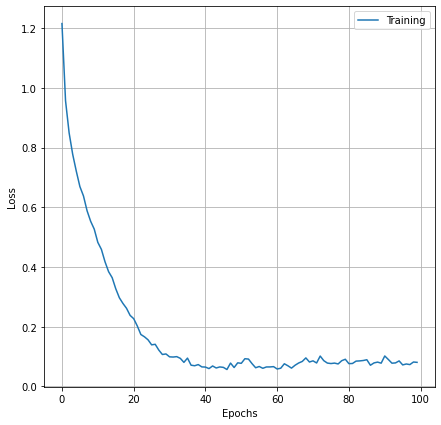

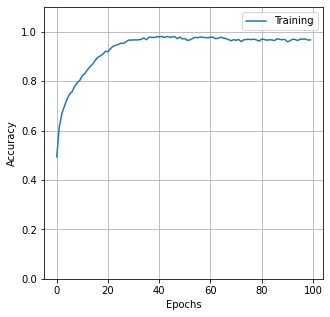

In [71]:
# pre epoch: 100 
start_t  = datetime.datetime.now()
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)
end_t = datetime.datetime.now()
print ((end_t - start_t).seconds)
np.savetxt("KS_D1A1300_loss.txt",history.history['loss'])
np.savetxt("KS_D1A1300_acc.txt",history.history['acc'])


plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])

# plt.plot(history.history['val_loss'])这个一定要干掉
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("loss_curve.pdf")
plt.show()

plt.figure(figsize=(5,5))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['acc'])

# plt.plot(history.history['val_acc'])这个一定要干掉
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.savefig("acc_curve.pdf")
plt.show()

plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("loss_curve.pdf")
plt.show()

plt.figure(figsize=(5,5))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.savefig("acc_curve.pdf")
plt.show()

# Validation

In [72]:
# load best weights TODO TODO
model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [73]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

(43750, 25, 25, 15, 1)

In [74]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

(43750, 4)

In [75]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

              precision    recall  f1-score   support

           0       0.84      0.80      0.82     17002
           1       0.77      0.85      0.81     13171
           2       0.68      0.73      0.71      9050
           3       0.83      0.56      0.67      4527

    accuracy                           0.78     43750
   macro avg       0.78      0.74      0.75     43750
weighted avg       0.78      0.78      0.78     43750



In [76]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [77]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
        #####################################################################################################################
    elif name == 'BO':
        target_names = ["Water", "Hippo grass",
                        "Floodplain grasses 1", "Floodplain grasses 2",
                        "Reeds", "Riparian", "Firescar", "Island interior",
                        "Acacia woodlands", "Acacia shrublands",
                        "Acacia grasslands", "Short mopane", "Mixed mopane",
                        "Exposed soils"]
    elif name == 'KS':
        target_names = ['Scrub','Willow swamp','Cabbage palm hammock','Cabbage palm/oak hammock', 'Slash pine','Oak / broadleaf hammock','Hardwood swamp',
                        'Graminoid marsh','Spartina marsh','Cattail marsh','Salt marsh','Mud flats','Water']
    elif name == 'PA':
        target_names = ['Water','Trees','Asphalt','Self-Blocking Bricks', 'Bitumen','Tiles','Shadows',
                        'Meadows','Bare Soil']
    elif name == 'URB':
        target_names = ['Asphalt Road','Grass','Tree','Roof']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [78]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

43680/43750 [============================>.] - ETA: 0s

In [83]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [84]:
# load the original image
X, y = loadData(dataset)

In [85]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [86]:
X,pca = applyPCA(X, numComponents=numComponents)

In [87]:
X = padWithZeros(X, PATCH_SIZE//2)

In [88]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

C:\Users\GJC\Anaconda3\envs\tensorflow_1_3\lib\site-packages\spectral\graphics\spypylab.py:27: MatplotlibDeprecationWarning:


The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.

C:\Users\GJC\Anaconda3\envs\tensorflow_1_3\lib\site-packages\spectral\graphics\spypylab.py:905: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



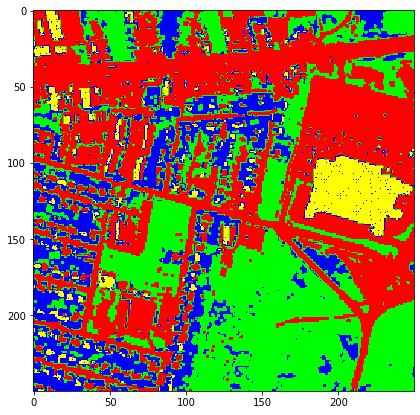

In [89]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

C:\Users\GJC\Anaconda3\envs\tensorflow_1_3\lib\site-packages\spectral\graphics\spypylab.py:905: MatplotlibDeprecationWarning:

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.



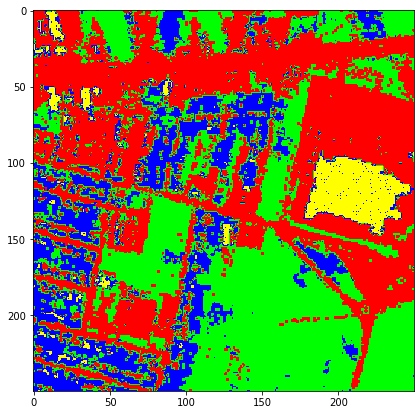

In [90]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [91]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)
spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)

# spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)